# Analyzing Car Accidents in Canada from 1999 - 2014 using a distributed environment in PySpark

In [176]:
import pyspark as py
import pandas as pd
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

In [177]:
spark = SparkSession.builder.appName('analysis').getOrCreate()
df = spark.read.csv('NCDB_1999_to_2014.csv',header=True)
df.show(10,False)

+------+------+------+------+-----+------+------+------+------+------+------+------+----+------+------+----+-----+-----+-----+------+------+------+
|C_YEAR|C_MNTH|C_WDAY|C_HOUR|C_SEV|C_VEHS|C_CONF|C_RCFG|C_WTHR|C_RSUR|C_RALN|C_TRAF|V_ID|V_TYPE|V_YEAR|P_ID|P_SEX|P_AGE|P_PSN|P_ISEV|P_SAFE|P_USER|
+------+------+------+------+-----+------+------+------+------+------+------+------+----+------+------+----+-----+-----+-----+------+------+------+
|1999  |01    |1     |20    |2    |02    |34    |UU    |1     |5     |3     |03    |01  |06    |1990  |01  |M    |41   |11   |1     |UU    |1     |
|1999  |01    |1     |20    |2    |02    |34    |UU    |1     |5     |3     |03    |02  |01    |1987  |01  |M    |19   |11   |1     |UU    |1     |
|1999  |01    |1     |20    |2    |02    |34    |UU    |1     |5     |3     |03    |02  |01    |1987  |02  |F    |20   |13   |2     |02    |2     |
|1999  |01    |1     |08    |2    |01    |01    |UU    |5     |3     |6     |18    |01  |01    |1986  |01  |M   

In [178]:
print("Total Rows in Dataset:",df.select("*").count())

Total Rows in Dataset: 5860405


In [179]:
print("Name of Columns - Printing for reference")
df.schema.names

Name of Columns - Printing for reference


['C_YEAR',
 'C_MNTH',
 'C_WDAY',
 'C_HOUR',
 'C_SEV',
 'C_VEHS',
 'C_CONF',
 'C_RCFG',
 'C_WTHR',
 'C_RSUR',
 'C_RALN',
 'C_TRAF',
 'V_ID',
 'V_TYPE',
 'V_YEAR',
 'P_ID',
 'P_SEX',
 'P_AGE',
 'P_PSN',
 'P_ISEV',
 'P_SAFE',
 'P_USER']

In [180]:
###################
###Cleaning Data###
###################
df = df.select("*").filter(col("C_MNTH").cast("int").isNotNull())

# Total No. of Collisions together for a month.

In [181]:
collisions_month_together = df.select(col("C_MNTH").alias("Month")).groupBy("Month").count().sort("Month")
collisions_month_together.show(collisions_month_together.count(),False)

+-----+------+
|Month|count |
+-----+------+
|01   |499874|
|02   |423287|
|03   |417814|
|04   |392533|
|05   |468235|
|06   |520010|
|07   |537693|
|08   |547045|
|09   |512790|
|10   |515911|
|11   |499080|
|12   |525748|
+-----+------+



In [182]:
collisions_month_together_pandas_df = collisions_month_together.select("*").toPandas()

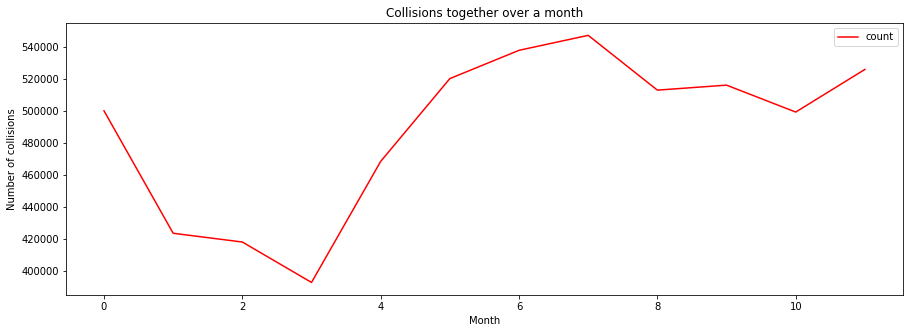

In [183]:
collisions_month_together = collisions_month_together_pandas_df.plot(figsize=(15,5),title='Collisions together over a month',color='red')
collisions_month_together.set_xlabel("Month")
collisions_month_together.set_ylabel("Number of collisions");

# Collisions grouped by the Day of Week

In [184]:
collisions_week_together = df.select(col("C_WDAY").alias("Day")).filter(col("Day") != "U").groupBy("Day").count().sort("Day")
collisions_week_together.show(collisions_week_together.count(),False)

+---+------+
|Day|count |
+---+------+
|1  |776012|
|2  |816265|
|3  |825560|
|4  |869653|
|5  |999725|
|6  |867188|
|7  |704679|
+---+------+



In [185]:
collisions_week_together_pandas_df = collisions_week_together.select("*").toPandas()

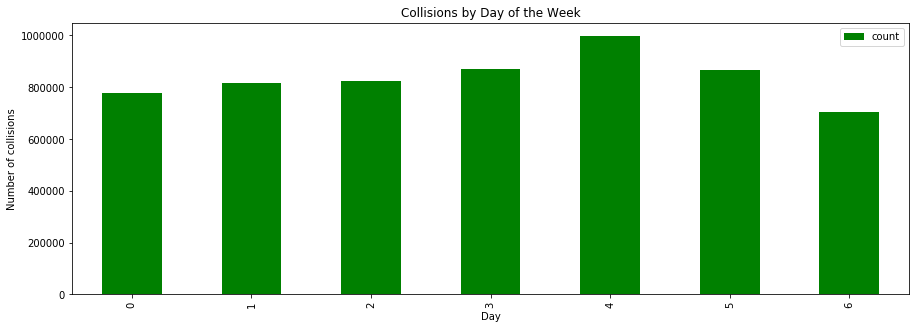

In [186]:
collisions_week_together = collisions_week_together_pandas_df.plot.bar(figsize=(15,5),title='Collisions by Day of the Week',color='green')
collisions_week_together.set_xlabel("Day")
collisions_week_together.set_ylabel("Number of collisions");

# Collisions grouped by the Hour of Day

In [187]:
collisions_hour_together = df.select(col("C_HOUR").alias("Hour")).filter(col("Hour") != "UU").groupBy("Hour").count().sort("Hour")
collisions_hour_together.show(5,False)

+----+-----+
|Hour|count|
+----+-----+
|00  |88477|
|01  |73379|
|02  |77496|
|03  |64036|
|04  |39815|
+----+-----+
only showing top 5 rows



In [188]:
collisions_hour_together_pandas_df = collisions_hour_together.select("*").toPandas()

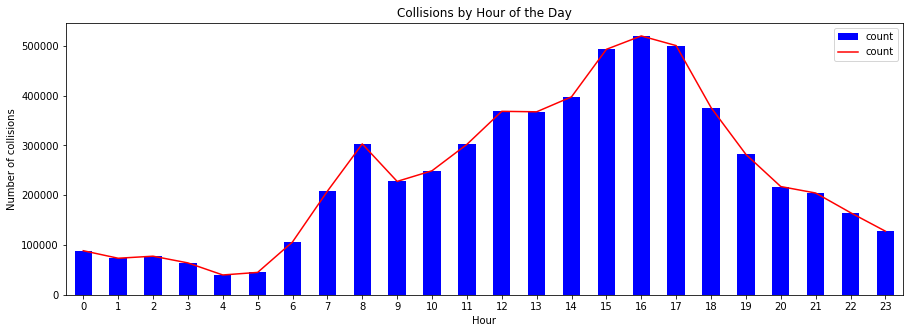

In [189]:
collisions_hour_together = collisions_hour_together_pandas_df.plot.bar(figsize=(15,5), label = "Bar" , title='Collisions by Hour of the Day',color='blue')
collisions_hour_together_pandas_df.plot(ax = collisions_hour_together, figsize=(15,5), label = "Line",color='red')

collisions_hour_together.set_xlabel("Hour")
collisions_hour_together.set_ylabel("Number of collisions");

# Total No. of collisions in a month for each month seperately

In [190]:
collisions_month = df.select(concat(col("C_YEAR"), lit("-"), col("C_MNTH")).alias("Date")).groupBy("Date").count()
collisions_month.show(5,False)

+-------+-----+
|Date   |count|
+-------+-----+
|1999-10|36269|
|2013-05|25633|
|2009-07|30136|
|1999-11|34859|
|2002-11|36328|
+-------+-----+
only showing top 5 rows



In [191]:
collisions_month_pandas_df = collisions_month.select("*").toPandas()

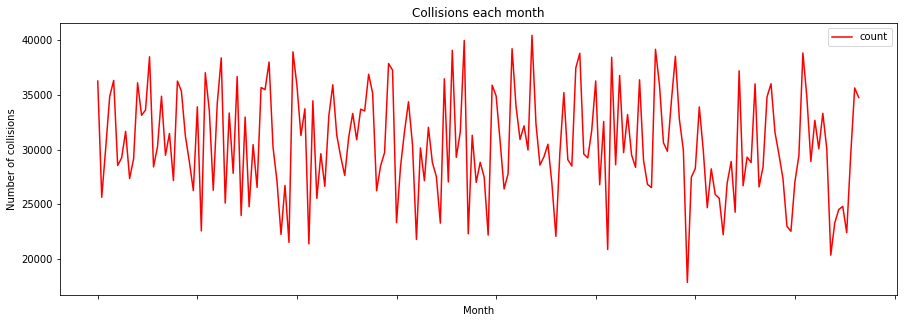

In [192]:
plot_collisions_month = collisions_month_pandas_df.plot(figsize=(15,5),x="Date",y="count",title='Collisions each month',color='red')
plot_collisions_month.set_xlabel("Month")
plot_collisions_month.set_ylabel("Number of collisions");

# No. of collisions grouped by severity in a month

In [193]:
severity = df.select(concat(col("C_YEAR"), lit("-"), col("C_MNTH")).alias("Date"), "C_SEV")
severity = severity.groupBy("Date","C_SEV").count()

severity_high = severity.filter(col("C_SEV") == 1)
severity_high.show(5,False)

severity_low = severity.filter(col("C_SEV") == 2)
severity_low.show(5,False)

+-------+-----+-----+
|Date   |C_SEV|count|
+-------+-----+-----+
|1999-07|1    |763  |
|2006-08|1    |768  |
|2003-07|1    |808  |
|2012-03|1    |424  |
|2008-11|1    |505  |
+-------+-----+-----+
only showing top 5 rows

+-------+-----+-----+
|Date   |C_SEV|count|
+-------+-----+-----+
|2007-04|2    |24010|
|2008-09|2    |28351|
|2009-05|2    |25499|
|2009-08|2    |31003|
|2002-06|2    |36646|
+-------+-----+-----+
only showing top 5 rows



In [194]:
severity_high_pandas_df = severity_high.select("*").toPandas()
severity_low_pandas_df = severity_low.select("*").toPandas()

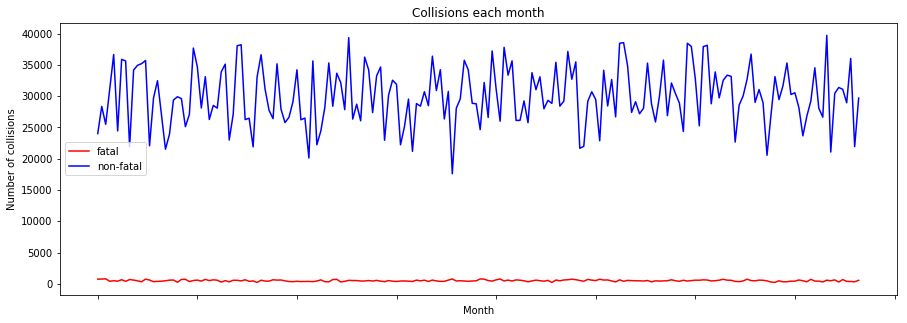

In [195]:
plot_severity_high = severity_high_pandas_df.plot(figsize=(15,5),label = "fatal", x="Date",y="count",title='Collisions each month',color='red')
plot_severity_low = severity_low_pandas_df.plot(ax = plot_severity_high, label = "non-fatal", figsize=(15,5),x="Date",y="count",title='Collisions each month',color='blue')
plot_severity_high.set_xlabel("Month")
plot_severity_high.set_ylabel("Number of collisions");

# No. of Collisions depending upon weather conditions

In [196]:
collisions_weather = df.select(col("C_WTHR").alias("Weather_Condition")).groupBy("Weather_Condition").count()
collisions_weather.sort("count").show(collisions_month.count(),False)

+-----------------+-------+
|Weather_Condition|count  |
+-----------------+-------+
|Q                |15011  |
|7                |15164  |
|5                |30330  |
|6                |82438  |
|U                |87769  |
|4                |354597 |
|3                |600099 |
|2                |600220 |
|1                |4074392|
+-----------------+-------+



1 Clear and sunny
2 Overcast, cloudy but no precipitation
3 Raining
4 Snowing, not including drifting snow
5 Freezing rain, sleet, hail
6 Visibility limitation e.g. drifting snow, fog, smog, dust, smoke, mist
7 Strong wind
Q Choice is other than the preceding values
U Unknown
X Jurisdiction does not provide this data element

# Severity of collisions based on weather

In [229]:
sev_collisions_weather = df.select(col("C_WTHR").alias("Weather_Condition"),col("C_SEV")).groupBy("Weather_Condition","C_SEV").count()
sev_collisions_weather = sev_collisions_weather.filter((col("Weather_Condition") != 'Q') & (col("Weather_Condition") != 'U')).sort("Weather_Condition")

sev_high_collisions_weather = sev_collisions_weather.filter(col("C_SEV") == 1)
sev_low_collisions_weather = sev_collisions_weather.filter(col("C_SEV") == 2)

sev_high_collisions_weather.show(sev_high_collisions_weather.count(),False)
sev_low_collisions_weather.show(sev_low_collisions_weather.count(),False)

+-----------------+-----+-----+
|Weather_Condition|C_SEV|count|
+-----------------+-----+-----+
|1                |1    |65074|
|2                |1    |12518|
|3                |1    |8262 |
|4                |1    |6907 |
|5                |1    |810  |
|6                |1    |3447 |
|7                |1    |580  |
+-----------------+-----+-----+

+-----------------+-----+-------+
|Weather_Condition|C_SEV|count  |
+-----------------+-----+-------+
|1                |2    |4009318|
|2                |2    |587702 |
|3                |2    |591837 |
|4                |2    |347690 |
|5                |2    |29520  |
|6                |2    |78991  |
|7                |2    |14584  |
+-----------------+-----+-------+



In [230]:
sev_high_collisions_weather_pandas_df = sev_high_collisions_weather.select("*").toPandas()
sev_low_collisions_weather_pandas_df = sev_low_collisions_weather.select("*").toPandas()

Text(0,0.5,'Non-Fatal Collision')

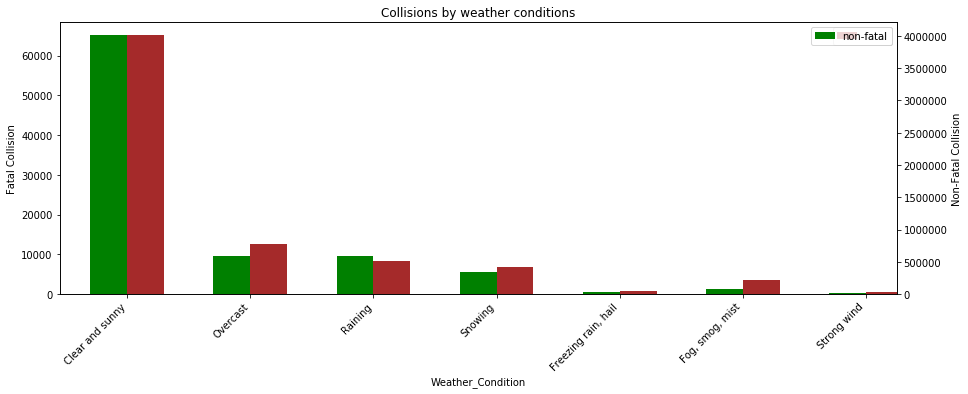

In [232]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

weather_type = ['Clear and sunny','Overcast','Raining','Snowing','Freezing rain, hail','Fog, smog, mist',
            'Strong wind']


plot_severity_high_weather = sev_high_collisions_weather_pandas_df.plot.bar(position = 0, ax = ax, figsize=(15,5) , label = "fatal", x="Weather_Condition",y="count",width = width, title='Collisions by weather conditions',color='brown')
plot_severity_low_weather = sev_low_collisions_weather_pandas_df.plot.bar(position = 1, ax = ax2, label = "non-fatal", figsize=(15,5),x="Weather_Condition",y="count", width = width,color='green')

ax.set_xticklabels(weather_type,ha='right',rotation = 45)
ax.set_ylabel('Fatal Collision')
ax2.set_ylabel('Non-Fatal Collision')

# Collision Severity by Road Configration

In [215]:
sev_collisions_rcfg = df.select(col("C_RCFG").alias("Road_Configration"),col("C_SEV")).groupBy("Road_Configration","C_SEV").count()
sev_collisions_rcfg = sev_collisions_rcfg.sort("Road_Configration")

sev_high_collisions_rcfg = sev_collisions_rcfg.filter(col("C_SEV") == 1)
sev_low_collisions_rcfg = sev_collisions_rcfg.filter(col("C_SEV") == 2)

sev_high_collisions_rcfg.show(sev_high_collisions_rcfg.count(),False)
sev_low_collisions_rcfg.show(sev_low_collisions_rcfg.count(),False)

+-----------------+-----+-----+
|Road_Configration|C_SEV|count|
+-----------------+-----+-----+
|01               |1    |57728|
|02               |1    |26665|
|03               |1    |2654 |
|04               |1    |920  |
|05               |1    |1162 |
|06               |1    |217  |
|07               |1    |115  |
|08               |1    |81   |
|09               |1    |11   |
|10               |1    |23   |
|QQ               |1    |3072 |
|UU               |1    |5981 |
+-----------------+-----+-----+

+-----------------+-----+-------+
|Road_Configration|C_SEV|count  |
+-----------------+-----+-------+
|01               |2    |2021539|
|02               |2    |2720067|
|03               |2    |286522 |
|04               |2    |22803  |
|05               |2    |50033  |
|06               |2    |5784   |
|07               |2    |894    |
|08               |2    |11699  |
|09               |2    |1732   |
|10               |2    |533    |
|QQ               |2    |141223 |
|UU        

01 Non-intersection e.g. 'mid-block'
02 At an intersection of at least two public roadways
03 Intersection with parking lot entrance/exit, private driveway or laneway
04 Railroad level crossing
05 Bridge, overpass, viaduct
06 Tunnel or underpass
07 Passing or climbing lane
08 Ramp
09 Traffic circle
10 Express lane of a freeway system
11 Collector lane of a freeway system
12 Transfer lane of a freeway system
QQ Choice is other than the preceding values
UU Unknown
XX Jurisdiction does not provide this data element

In [216]:
sev_high_collisions_rcfg_pandas_df = sev_high_collisions_rcfg.select("*").toPandas()
sev_low_collisions_rcfg_pandas_df = sev_low_collisions_rcfg.select("*").toPandas()

Text(0,0.5,'Non-Fatal Collision')

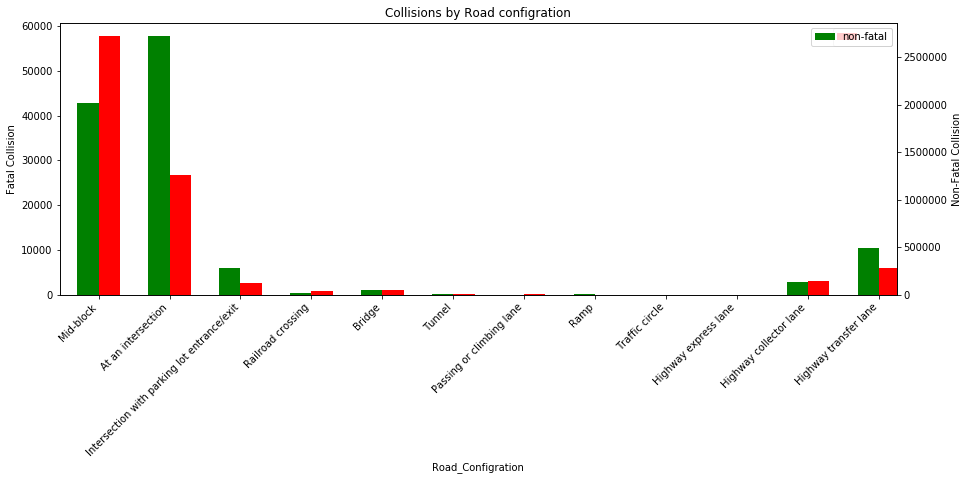

In [219]:
fig = plt.figure()
ax = fig.add_subplot(111) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

rcfg_type = ['Mid-block','At an intersection','Intersection with parking lot entrance/exit',
            'Railroad crossing','Bridge','Tunnel','Passing or climbing lane',
             'Ramp','Traffic circle','Highway express lane',
             'Highway collector lane','Highway transfer lane']

plot_severity_high_rcfg = sev_high_collisions_rcfg_pandas_df.plot.bar(position = 0, ax = ax, figsize=(15,5) , label = "fatal", x="Road_Configration",y="count",width = width, title='Collisions by Road configration',color='red')
plot_severity_low_rcfg = sev_low_collisions_rcfg_pandas_df.plot.bar(position = 1, ax = ax2, label = "non-fatal", figsize=(15,5),x="Road_Configration",y="count", width = width,color='green')
ax.set_xticklabels(rcfg_type,ha='right',rotation=45)
ax.set_ylabel('Fatal Collision')
ax2.set_ylabel('Non-Fatal Collision')